In [71]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import cv2

def max_connected_area_2(matrix, m, n, k):
    matrix = np.array(matrix, dtype=np.uint8)

    # Создаем ядро размера (m, n) для подсчета количества соседей
    kernel = np.ones((m, n), dtype=np.uint8)
    
    # Применяем свертку для подсчета количества `1` в каждом окне
    neighbor_count = cv2.filter2D(matrix, -1, kernel)
    
    # Создаем маску только для точек, у которых количество соседей >= k
    valid_points = (neighbor_count >= k) & (matrix == 1)
    
    # Находим все связанные компоненты в "валидных" точках
    num_labels, labeled_matrix = cv2.connectedComponents(valid_points.astype(np.uint8))

    # Подсчитываем размер каждой области
    areas_sizes = []
    for label in range(1, num_labels):  # Пропускаем метку 0 (фон)
        areas_sizes.append(np.sum(labeled_matrix == label))

    # Создаем маски для каждой области
    areas_mask = [(labeled_matrix == label) for label in range(1, num_labels)]

    return areas_sizes, areas_mask


In [73]:

def max_connected_area(matrix, tresh_level = 100):
    matrix = np.array(matrix)
    rows, cols = matrix.shape
    visited = np.zeros((rows, cols), dtype=bool)

    def dfs(r, c):
        # Стек для симуляции DFS
        area_ = np.zeros_like(visited, dtype=np.uint8)
        stack = [(r, c)]
        area = 0
        while stack:
            x, y = stack.pop()
            if not (0 <= x < rows and 0 <= y < cols) or matrix[x, y] == 0 or visited[x, y]:
                continue
            visited[x, y] = True
            area += 1
            area_[x,y] = 1
            # Добавляем всех соседей (включая диагонали)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                stack.append((x + dx, y + dy))
        return area, area_

    
    # Находим все индексы, где `1`, и запускаем DFS только для этих областей
    ones_positions = np.argwhere(matrix == 1)
    areas_sizes = []
    areas_mask = []
    for r, c in ones_positions:
        if not visited[r, c]:
            area, area_ = dfs(r, c)
            if area > tresh_level:
                areas_sizes.append(area)
                areas_mask.append(area_)

    return areas_sizes, areas_mask


In [74]:
#Parralel load
from concurrent.futures import ThreadPoolExecutor

def load_image(image_path):
    image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    return image

def load_images(path):
    # Получаем список файлов с нужными расширениями
    listdr = [f for f in os.listdir(path) if f.lower().endswith(('.png'))]
    images = []

    # Загружаем изображения параллельно
    with ThreadPoolExecutor() as executor:
        image_paths = [os.path.join(path, el) for el in listdr]
        images = list(executor.map(load_image, image_paths))
    
    return images

# Пример использования
healthy = load_images('../Здоровая кожа')
print("Загрузка изображений здоровой кожи завершена")

skleroderm = load_images('../склеродермия')
print("Загрузка изображений с склеродермией завершена")

Загрузка изображений здоровой кожи завершена
Загрузка изображений с склеродермией завершена


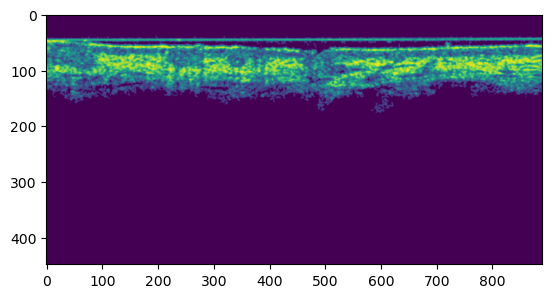

In [75]:
def filterImage(image, bound = 30):
    ret,thresh1 = cv2.threshold(image,bound,1,cv2.THRESH_BINARY)
    areas_sizes, areas_mask = max_connected_area(thresh1, 10)
    #mask = np.sum(areas_mask)
    max_area = max(areas_sizes)
    index = areas_sizes.index(max_area)
    fiiltred = image * areas_mask[index]
    plt.imshow(fiiltred)
    plt.show()
from image_processor import ImageProcessor
def image_filter(image):
    processor = ImageProcessor(image)
    blured = processor.blurGaussian((3, 3), 0, 0)
    filterImage(blured)
image_filter(skleroderm[5])

Среднее значение в области 120.9412902763513


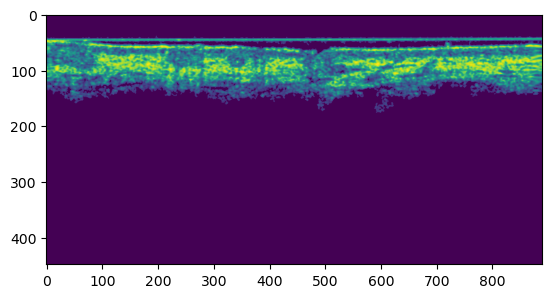

In [85]:
def filterImage(image, bound = 30):
    ret,thresh1 = cv2.threshold(image,bound,1,cv2.THRESH_BINARY)
    areas_sizes, areas_mask = max_connected_area_2(thresh1, 3, 3, 5)
    #mask = np.sum(areas_mask)
    max_area = max(areas_sizes)
    index = areas_sizes.index(max_area)
    # убираем дефект в вершине
    #kernel = np.ones((10,10),np.uint8)
    #opening = cv2.morphologyEx(np.uint8(areas_mask[index]), cv2.MORPH_OPEN, kernel)
    fiiltred = image * areas_mask[index]

    #
    print(f'Среднее значение в области {np.mean(image[areas_mask[index]])}')
    plt.imshow(fiiltred)
    plt.show()
from image_processor import ImageProcessor
def image_filter(image):
    processor = ImageProcessor(image)
    blured = processor.blurGaussian((3, 3), 0, 0)
    filterImage(blured)
image_filter(skleroderm[5])

Среднее значение в области 120.34749910856105


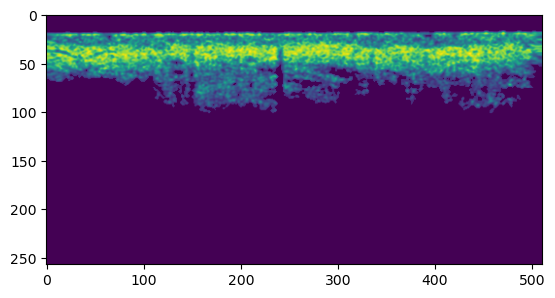

In [88]:
image_filter(healthy[1])